In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# Build the dataset

block_size = 3 # Context lenght: cb de characteres pris en compte 
X, Y = [], []

for w in words:
    context = [0] * block_size
    
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [46]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [47]:
C = torch.randn((27, 2))

In [48]:
C[5]

tensor([0.9418, 0.6927])

In [49]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.9418, 0.6927])

In [50]:
C[X]

tensor([[[-0.0720, -0.3240],
         [-0.0720, -0.3240],
         [-0.0720, -0.3240]],

        [[-0.0720, -0.3240],
         [-0.0720, -0.3240],
         [ 0.9418,  0.6927]],

        [[-0.0720, -0.3240],
         [ 0.9418,  0.6927],
         [-0.8570, -1.3792]],

        ...,

        [[ 0.4431,  1.0380],
         [ 0.4431,  1.0380],
         [ 1.0378,  0.8281]],

        [[ 0.4431,  1.0380],
         [ 1.0378,  0.8281],
         [ 0.4431,  1.0380]],

        [[ 1.0378,  0.8281],
         [ 0.4431,  1.0380],
         [-0.7725, -0.9415]]])

In [51]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [52]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [53]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

On ne peut pas faire le produit matriciel donc il faut concatener deux des dimensions de emb en une seule

In [54]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

Mais pour généraliser il y a aussi une autre fonction

In [55]:
torch.cat(torch.unbind(emb, 1), 1).shape
# très innéficace

torch.Size([228146, 6])

Il existe une manière encore plus efficace car le stockage de chaque élément de la matrice est fait de facon qu'ils soient tous des vecteurs, donc il est possible de les réorganiser sans utiliser bcp de mémoire grâce à la méthode view()

In [56]:
emb.view(-1, 6).shape

torch.Size([228146, 6])

In [57]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.1351, -0.4990,  0.9530,  ...,  0.9504,  0.3297, -0.0207],
        [-0.8805, -0.1143, -0.5064,  ...,  0.9179,  0.7347,  0.1578],
        [-0.9268,  0.6639,  0.9909,  ..., -0.6752,  0.9642, -0.8206],
        ...,
        [-0.9497,  0.9818, -0.9921,  ..., -0.9109,  0.9998, -0.9405],
        [-0.9935,  0.9962, -0.8816,  ..., -0.9388,  1.0000, -0.9954],
        [-0.7802,  0.8821,  0.9009,  ..., -0.9065,  0.9996, -0.9275]])

In [58]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [59]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [60]:
counts = logits.exp()

In [61]:
prob = counts / counts.sum(1, keepdims = True)
prob.shape

torch.Size([228146, 27])

In [62]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [63]:
# --------------- De façon clair ---------------

In [30]:
# Dataset
X.shape, Y.shape 

(torch.Size([228146, 3]), torch.Size([228146]))

In [31]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [32]:
# nombre total de parametres
sum(p.nelement() for p in parameters) 

3481

In [67]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = - prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [33]:
# on peut aussi simplifier counts, prob et loss avec une nouvelle fonction
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

In [34]:
for p in parameters:
    p.requires_grad = True

In [35]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [77]:
lri = []
lossi = []

for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # foward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stat
    #lri.append(lre[i])
    #lossi.append(loss.item())

print(loss.item())


2.1062986850738525


In [78]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3624, grad_fn=<NllLossBackward0>)

In [38]:
#plt.plot(lri, lossi)

On est convaincu que le bon step est 0.1

In [79]:
# Training split / validation split / test split
# 80%              10%                10%


In [80]:
# Repartons de zero pour split le dataset et bien entrainer

In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()

In [16]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [17]:
# Build the dataset

def build_dataset(words):
    block_size = 3 # Context lenght: cb de characteres pris en compte 
    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [19]:
# on peut aussi simplifier counts, prob et loss avec une nouvelle fonction
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(19.5116)

In [20]:
for p in parameters:
    p.requires_grad = True

for i in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # foward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())


2.4780728816986084


In [21]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.4253, grad_fn=<NllLossBackward0>)

In [22]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4270, grad_fn=<NllLossBackward0>)

Notre neural net fait du underfitting donc il faut augmenter la taille du neural network

In [75]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [76]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(26.0047)

In [77]:
for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []

In [84]:


for i in range(50000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # foward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stat
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


2.202267646789551


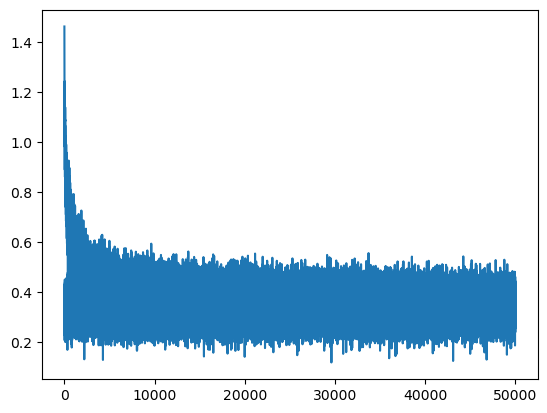

In [85]:
plt.plot(stepi, lossi)

In [86]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1934, grad_fn=<NllLossBackward0>)

In [87]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1607, grad_fn=<NllLossBackward0>)

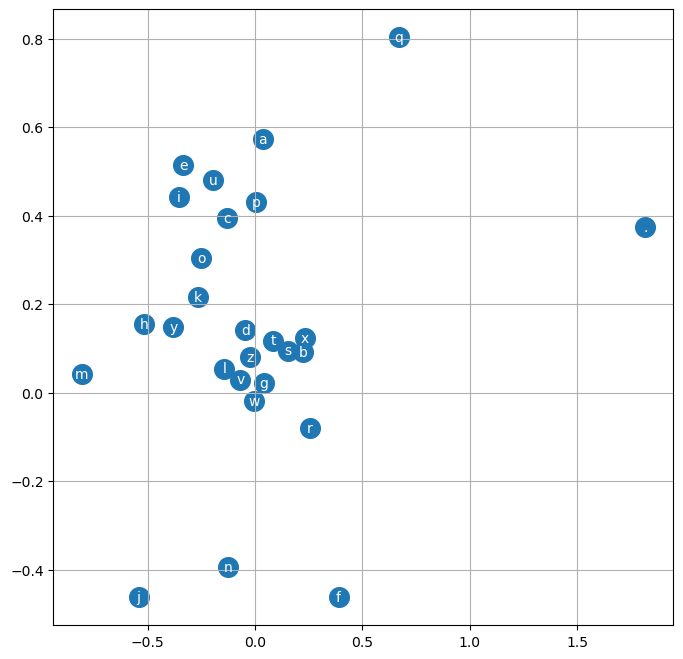

In [88]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [89]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1908, grad_fn=<NllLossBackward0>)

In [90]:
# ------------------- Makemore final version --------------------

In [99]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()

In [101]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [102]:
# Build the dataset

def build_dataset(words):
    block_size = 3 # Context lenght: cb de characteres pris en compte 
    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [106]:
taille_block = 32
batch = 32
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, taille_block), generator=g)
W1 = torch.randn((3*taille_block, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [108]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 3*taille_block) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(35.9725)

In [109]:
for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []

In [116]:


for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch,))

    # foward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 3*taille_block) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stat
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


2.1643624305725098


In [117]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 3*taille_block) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.2289, grad_fn=<NllLossBackward0>)